# Texture Mapping

__textures, slices, samplers, combined descriptors__

In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav==13.1.0
    !pip install git+https://github.com/rendervous/vulky_project.git
except:
    print("Executing locally")

Executing locally


In [2]:
import vulky as vk
import torch
vk.create_device(debug=True)
SCREEN_WIDTH = 512
SCREEN_HEIGHT = 512
render_target = vk.render_target(
    image_format=vk.Format.VEC4,
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)
depth_buffer = vk.depth_stencil(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)
transforms = vk.object_buffer(
    layout=vk.Layout.from_structure(
        vk.LayoutAlignment.STD430,
        projection=vk.mat4,
        view=vk.mat4
    )
)
with transforms as b:
    b.projection = vk.mat4.perspective()
    b.view = vk.mat4.look_at(vk.vec3(0.0, 0.5, -2.0), vk.vec3(0.0, 0.0, 0.0), vk.vec3(0.0, 1.0, 0.0))

[INFO] Debug instance created...
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserted device layer "VK_LAYER_NV_optimus" (C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll)
[PRINT] vkCreateDevice layer callstack setup to:
[PRINT]    <Application>
[PRINT]      ||
[PRINT]    <Loader>
[PRINT]      ||
[PRINT]    VK_LAYER_NV_optimus
[PRINT]            Type: Implicit
[PRINT]                Disable Env Var:  DISABLE_LAYER_NV_OPTIMUS_1
[PRINT]            Manifest: C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\nv-vk64.json
[PRINT]            Library:  C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll
[PRINT]      ||
[PRINT]    VK_LAYER_OBS_HOOK
[PRINT]            Type: Implici

In [3]:
texture_data = torch.zeros(8, 8, 4)
texture_data[..., 3] = 1.0
texture_data[::2, ::2] = 1.0
texture_data[1::2, 1::2] = 1.0
texture_data = torch.nn.functional.interpolate(texture_data.unsqueeze(0).permute(0, 3, 1, 2), scale_factor=32, mode='nearest').permute(0, 2, 3, 1).squeeze(0)

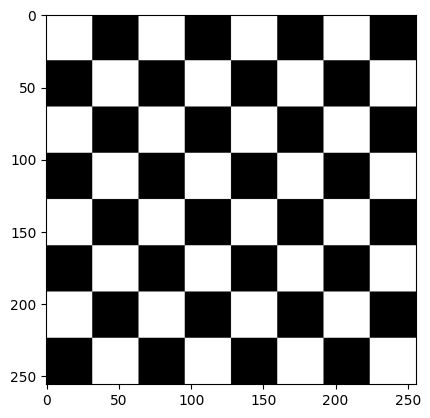

In [4]:
import matplotlib.pyplot as plt
plt.imshow(texture_data)
plt.show()

In [5]:
texture = vk.image_2D(vk.Format.VEC4,
                      width=256, height=256)
texture.subresource(0).load(texture_data)

In [6]:
with vk.graphics_manager() as man:
    for i in range(1, texture.get_mip_count()):
        man.blit_image(texture.subresource(i-1,0), texture.subresource(i,0), filter=vk.Filter.LINEAR)

In [7]:
vertex_shader_code = """
#version 450
#extension GL_EXT_scalar_block_layout: enable

layout(location = 0) out vec2 out_coordinates;

layout(std430, set=0, binding=0) uniform Globals{
    mat4 Proj;
    mat4 View;
};

vec2[] quad = {
    vec2(-1.0, -1.0), 
    vec2(1.0, -1.0),
    vec2(-1.0, 1.0),
    vec2(-1.0, 1.0),
    vec2(1.0, -1.0),
    vec2(1.0, 1.0)
};

void main()
{
    vec2 q = quad[gl_VertexIndex];
    vec4 P = vec4(q.x * 1000, 0, q.y * 1000, 1.0);
    gl_Position = Proj * (View * P);
    out_coordinates = P.xz;
}
"""
fragment_shader_code = """
#version 450
layout(location = 0) in vec2 in_coordinates;
layout(location = 0) out vec4 out_color;

layout(set=0, binding=1) uniform sampler2D image;

void main()
{
    out_color = texture(image, in_coordinates);
}
"""

In [8]:
pipeline = vk.pipeline_graphics()
pipeline.attach(0, render_target=vk.Format.VEC4)
pipeline.attach(1, depth_buffer=vk.Format.DEPTH_STENCIL)
pipeline.layout(set=0, binding=0, transforms=vk.DescriptorType.UNIFORM_BUFFER)
pipeline.layout(set=0, binding=1, image=vk.DescriptorType.COMBINED_IMAGE)
with pipeline.shader_stages(vk.ShaderStage.VERTEX):
    pipeline.load_shader_from_source(vertex_shader_code)
with pipeline.shader_stages(vk.ShaderStage.FRAGMENT):
    pipeline.load_shader_from_source(fragment_shader_code)
pipeline.close()

In [9]:
framebuffer = pipeline.create_framebuffer(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT,
    render_target=render_target,
    depth_buffer=depth_buffer
)

In [10]:
sampler = vk.sampler(mipmap_mode=vk.MipMapMode.NONE)

In [11]:
global_bindings = pipeline.create_descriptor_set_collection(set=0, count=1)
global_bindings[0].update(
    transforms=transforms,
    image=(texture, sampler)
)

In [12]:
man = vk.graphics_manager()
man.clear_color(render_target, (0.0, 0.0, 0.4, 1.0))
man.clear_depth_stencil(depth_buffer, 1.0, 0)
man.set_pipeline(pipeline)
man.set_framebuffer(framebuffer)
man.bind(global_bindings[0])
man.dispatch_primitives(vertices=6)
man.freeze()

In [13]:
vk.submit(man)

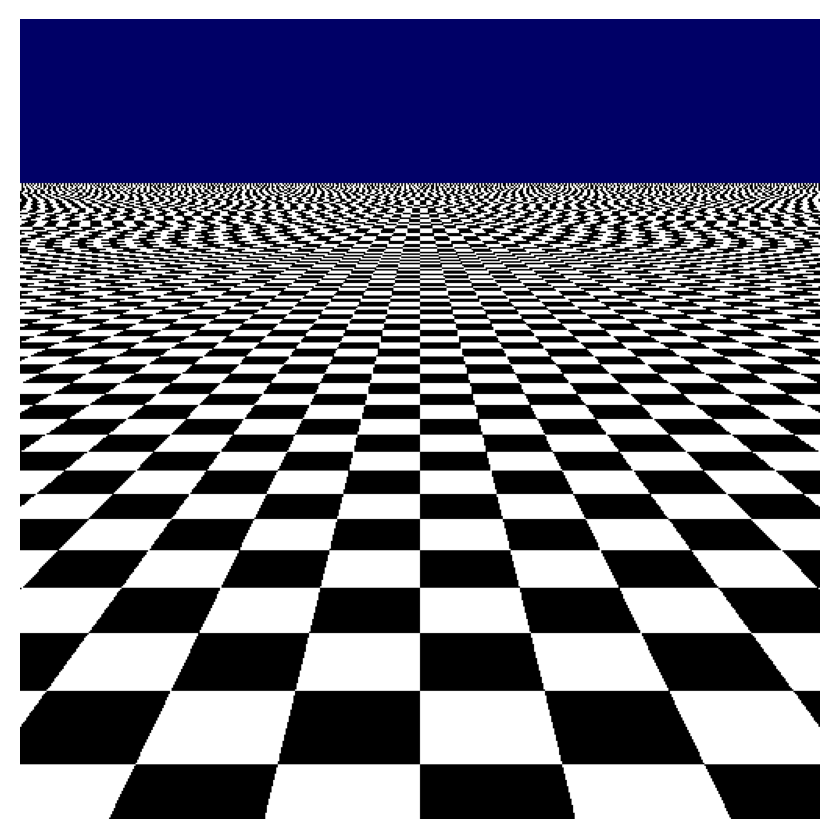

In [14]:
staging = vk.tensor(render_target.height, render_target.width, 4) 
render_target.save(staging)

plt.figure(figsize=(4,4), dpi=200)
plt.imshow(staging.cpu())
plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.show()

In [15]:
sampler = vk.sampler_linear(enable_anisotropy=True, max_anisotropy=16)
global_bindings[0].update(
    image=(texture, sampler)
)

In [16]:
vk.submit(man)
render_target.save(staging)

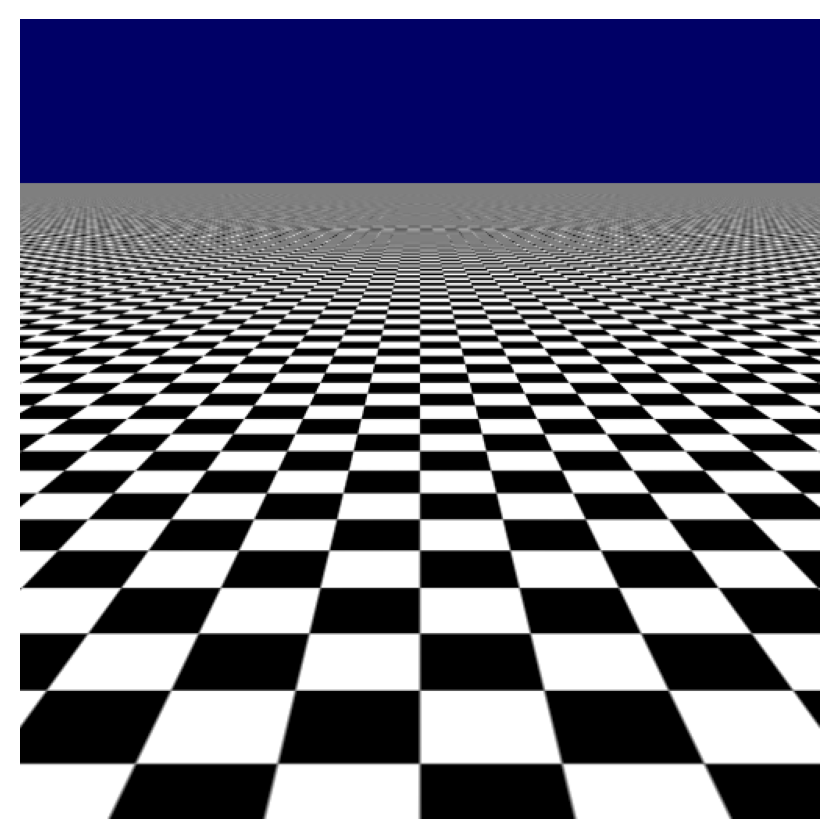

In [17]:
plt.figure(figsize=(4,4), dpi=200)
plt.imshow(staging.cpu())
plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.savefig('teaser6.jpg')
plt.show()